In [7]:

# 1. Importing required libraries and loading the dataset

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Find all .csv.gz files in the working directory
DATA_DIR = Path(".")
files = sorted(DATA_DIR.glob("0000000000*.csv.gz"))
files

# Concatenate all daily summary files into a single DataFrame
df = pd.concat(
    (pd.read_csv(f, compression="gzip") for f in files),
    ignore_index=True
)

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7293526 entries, 0 to 7293525
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   user_id                  object 
 1   event_date               object 
 2   platform                 object 
 3   install_date             object 
 4   country                  object 
 5   total_session_count      int64  
 6   total_session_duration   float64
 7   match_start_count        int64  
 8   match_end_count          int64  
 9   victory_count            int64  
 10  defeat_count             int64  
 11  server_connection_error  int64  
 12  iap_revenue              float64
 13  ad_revenue               float64
dtypes: float64(3), int64(6), object(5)
memory usage: 779.0+ MB


In [8]:
files

[PosixPath('000000000000.csv.gz'),
 PosixPath('000000000001.csv.gz'),
 PosixPath('000000000002.csv.gz'),
 PosixPath('000000000003.csv.gz'),
 PosixPath('000000000004.csv.gz'),
 PosixPath('000000000005.csv.gz'),
 PosixPath('000000000006.csv.gz'),
 PosixPath('000000000007.csv.gz'),
 PosixPath('000000000008.csv.gz'),
 PosixPath('000000000009.csv.gz'),
 PosixPath('000000000010.csv.gz'),
 PosixPath('000000000011.csv.gz'),
 PosixPath('000000000012.csv.gz'),
 PosixPath('000000000013.csv.gz'),
 PosixPath('000000000014.csv.gz'),
 PosixPath('000000000015.csv.gz'),
 PosixPath('000000000016.csv.gz')]

In [9]:
# 2. Preprocessing: Date conversion & feature creation

# Convert event and install dates to datetime objects
df["event_date"] = pd.to_datetime(df["event_date"])
df["install_date"] = pd.to_datetime(df["install_date"])

df[["event_date", "install_date"]].dtypes

# Compute total revenue as the sum of IAP and Ad revenue
df["total_revenue"] = df["iap_revenue"].fillna(0) + df["ad_revenue"].fillna(0)

# Mark install-day activity (D1 rows)
df["is_day1"] = df["event_date"] == df["install_date"]

# Compute number of days since installation
df["days_since_install"] = (df["event_date"] - df["install_date"]).dt.days

df[["user_id", "event_date", "install_date", "is_day1", "days_since_install"]].head()


,user_id,event_date,install_date,is_day1,days_since_install
0,C6C0A027C49B98BA,2024-02-16,2024-02-11,False,5
1,EE03D492BC0ED08C,2024-03-08,2024-02-01,False,36
2,5CAA4AF817354059,2024-03-12,2024-03-12,True,0
3,EF0DE79217D56E72,2024-02-16,2023-07-24,False,207
4,6DD3D1FC631486F0,2024-03-02,2024-03-01,False,1


In [10]:
# 3. First-Day Engagement Segmentation (Low / Mid / High)

# Filter only Day-1 (install day) rows
day1 = df[df["is_day1"]].copy()

# Keep only users who played at least one session on D1
day1 = day1[day1["total_session_count"] > 0]

# Compute quartiles based on D1 total session duration
q25 = day1["total_session_duration"].quantile(0.25)
q75 = day1["total_session_duration"].quantile(0.75)
print(q25, q75)

# Segmentation function based on total D1 duration
def segment_duration(x):
    if x <= q25:
        return "Low"
    elif x <= q75:
        return "Mid"
    else:
        return "High"

# Assign each user a D1 engagement segment
day1["d1_engagement_segment"] = day1["total_session_duration"].apply(segment_duration)
user_segments = day1[["user_id", "d1_engagement_segment"]].drop_duplicates()

# Merge segment labels back into the full dataset
df = df.merge(user_segments, on="user_id", how="left")

df["d1_engagement_segment"].value_counts()


285.62 1461.174


d1_engagement_segment
Mid     1089982
High     903128
Low      416392
Name: count, dtype: int64

In [11]:
# 4. Retention calculation function
# Computes cohort-based retention for any given day.
# Retention is calculated per D1 engagement segment and platform.

def compute_retention(df, day: int) -> pd.DataFrame:
    """
    Computes retention for a specified day (D1, D3, D7, D14, D30).
    Returns retention grouped by D1 engagement segment and platform.
    """
    # Base cohort: install-day users
    base = df[df["days_since_install"] == 0][
        ["user_id", "d1_engagement_segment", "platform"]
    ].drop_duplicates()

    # Count install-day users per segment and platform
    total_users = (
        base.groupby(["d1_engagement_segment", "platform"])["user_id"]
        .nunique()
        .reset_index()
        .rename(columns={"user_id": "install_users"})
    )

    # Target-day activity: days_since_install == day - 1
    target = df[df["days_since_install"] == (day - 1)][["user_id"]].drop_duplicates()
    target["is_retained"] = 1

    # Merge base cohort with target activity
    merged = base.merge(target, on="user_id", how="left")
    merged["is_retained"] = merged["is_retained"].fillna(0)

    # Compute retention rate
    ret = (
        merged.groupby(["d1_engagement_segment", "platform"])["is_retained"]
        .mean()
        .reset_index()
        .merge(total_users,
               on=["d1_engagement_segment", "platform"],
               how="left")
    )

    ret.rename(columns={"is_retained": f"D{day}_retention"}, inplace=True)
    return ret

# Compute retention for all key days
ret_d1 = compute_retention(df, 1)
ret_d3 = compute_retention(df, 3)
ret_d7 = compute_retention(df, 7)
ret_d14 = compute_retention(df, 14)
ret_d30 = compute_retention(df, 30)


In [12]:
# 5. Merge all retention tables & compute revenue per user

from functools import reduce

# Combine all retention dataframes into one
ret_tables = [ret_d1, ret_d3, ret_d7, ret_d14, ret_d30]

ret_all = reduce(
    lambda left, right: pd.merge(
        left, right,
        on=["d1_engagement_segment", "platform", "install_users"],
        how="outer",
    ),
    ret_tables,
)

# Filter first 30 days
df_30 = df[df["days_since_install"].between(0, 29)].copy()

# Compute total and average revenue per segment/platform
rev_seg = (
    df_30.groupby(["d1_engagement_segment", "platform"])["total_revenue"]
    .agg(["sum", "mean"])
    .reset_index()
)

# Merge revenue with retention
summary = ret_all.merge(
    rev_seg,
    on=["d1_engagement_segment", "platform"],
    how="left"
)

# Compute D0–D30 revenue per user
summary["rev_per_user_D30"] = summary["sum"] / summary["install_users"]

summary


,d1_engagement_segment,platform,D1_retention,install_users,D3_retention,D7_retention,D14_retention,D30_retention,sum,mean,rev_per_user_D30
0,High,android,1.0,191697,0.320068,0.115703,0.046292,0.001450,81633.051030,0.130520,0.425844
1,High,ios,1.0,72371,0.363364,0.149991,0.067182,0.002142,80261.626510,0.289043,1.109030
2,Low,android,1.0,189365,0.082481,0.027772,0.010007,0.000322,2640.854912,0.008828,0.013946
3,Low,ios,1.0,74709,0.079562,0.027453,0.009959,0.000241,2939.590278,0.025069,0.039347
4,Mid,android,1.0,385039,0.155696,0.050896,0.017842,0.000512,17545.319048,0.022357,0.045568
5,Mid,ios,1.0,143089,0.160739,0.056580,0.022196,0.000713,25562.807455,0.083758,0.178650


In [13]:
# 6. Behavioral metrics (sessions, duration, win-rate, errors)

df_30 = df[df["days_since_install"].between(0, 29)].copy()

behavior = (
    df_30
    .groupby(["d1_engagement_segment", "platform"])
    .agg(
        avg_daily_sessions=("total_session_count", "mean"),
        avg_daily_duration=("total_session_duration", "mean"),
        avg_win_rate=("victory_count",
                       lambda x: x.sum() /
                       (x.sum() + df_30.loc[x.index, "defeat_count"].sum())),
        avg_server_errors=("server_connection_error", "mean"),
    )
    .reset_index()
)

behavior


,d1_engagement_segment,platform,avg_daily_sessions,avg_daily_duration,avg_win_rate,avg_server_errors
0,High,android,1.907712,2426.441070,0.694806,0.023079
1,High,ios,2.086423,2810.228739,0.667522,0.047119
2,Low,android,1.221489,375.881052,0.574145,0.119632
3,Low,ios,1.223754,484.034955,0.550393,0.049421
4,Mid,android,1.389399,837.713450,0.724546,0.023019
5,Mid,ios,1.463332,1044.619309,0.692512,0.021101


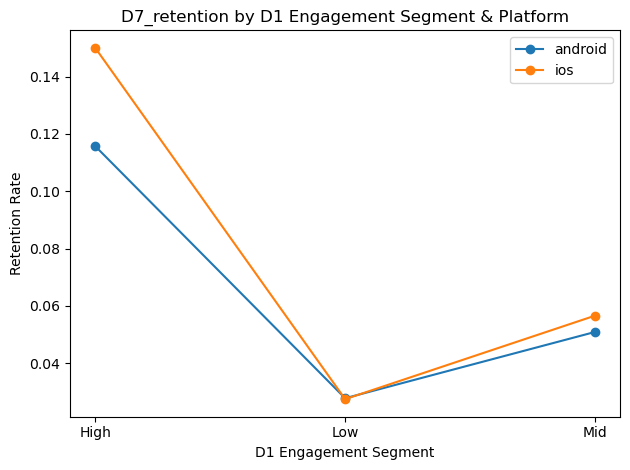

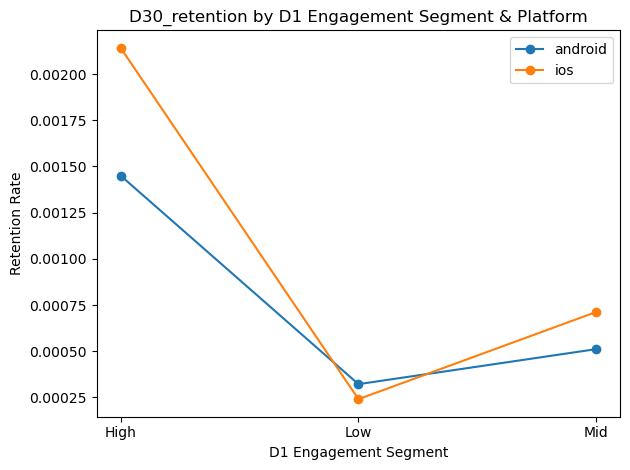

In [14]:
# 7. Retention visualizations (D7, D30)

for day, col in [(7, "D7_retention"), (30, "D30_retention")]:
    fig, ax = plt.subplots()
    for plat in summary["platform"].unique():
        sub = summary[summary["platform"] == plat]
        ax.plot(sub["d1_engagement_segment"], sub[col], marker="o", label=plat)

    ax.set_title(f"{col} by D1 Engagement Segment & Platform")
    ax.set_xlabel("D1 Engagement Segment")
    ax.set_ylabel("Retention Rate")
    ax.legend()
    plt.tight_layout()
    plt.show()


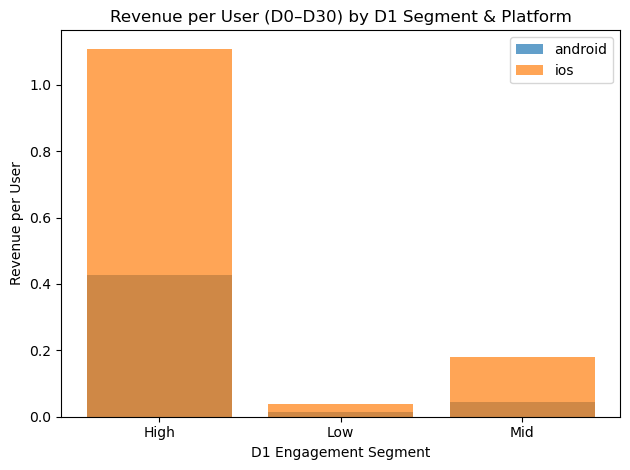

In [15]:
# 8. Revenue per user visualization

fig, ax = plt.subplots()
for plat in summary["platform"].unique():
    sub = summary[summary["platform"] == plat]
    ax.bar(sub["d1_engagement_segment"], sub["rev_per_user_D30"],
           alpha=0.7, label=plat)

ax.set_title("Revenue per User (D0–D30) by D1 Segment & Platform")
ax.set_xlabel("D1 Engagement Segment")
ax.set_ylabel("Revenue per User")
ax.legend()
plt.tight_layout()
plt.show()


In [16]:
# 9. Country-level analysis: top countries by installs

# Replace missing countries with UNKNOWN
df["country"] = df["country"].fillna("UNKNOWN")

# Compute D1 installs per country
d1_country = (
    df[df["days_since_install"] == 0]
    .groupby("country")["user_id"]
    .nunique()
    .reset_index()
    .rename(columns={"user_id": "install_users"})
    .sort_values("install_users", ascending=False)
)

d1_country.head(15)

# Select the top 10 countries
top_countries = d1_country.head(10)["country"].tolist()
top_countries


['Brazil',
 'Türkiye',
 'Russia',
 'India',
 'Vietnam',
 'United States',
 'Ukraine',
 'Indonesia',
 'Philippines',
 'Kazakhstan']

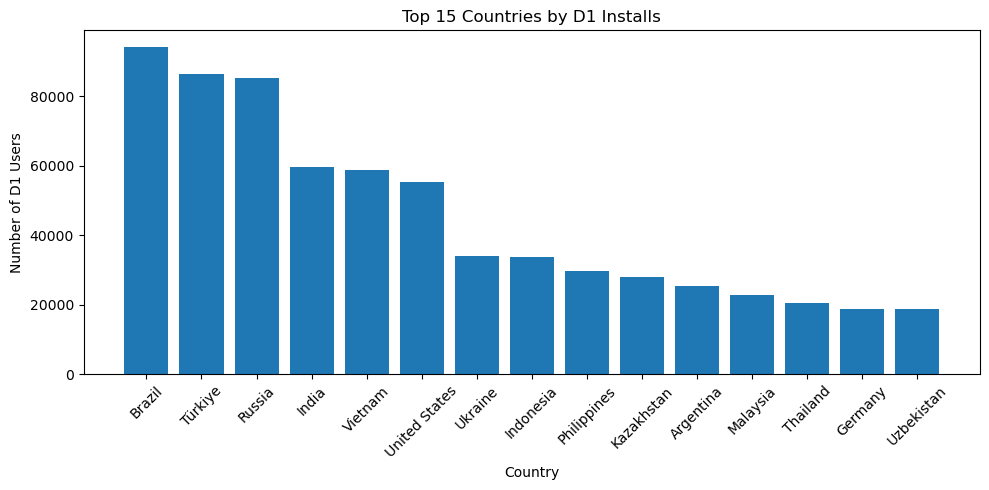

In [17]:
# 10. Country install distribution visualization

top_d1_for_plot = d1_country.head(15)

plt.figure(figsize=(10, 5))
plt.bar(top_d1_for_plot["country"], top_d1_for_plot["install_users"])
plt.title("Top 15 Countries by D1 Installs")
plt.xlabel("Country")
plt.ylabel("Number of D1 Users")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
# 11. Country-level D30 retention

def compute_retention_country(df, day: int, top_countries=None) -> pd.DataFrame:
    """
    Computes D30 retention grouped by country + D1 engagement segment + platform.
    Optionally filters for a given list of top countries.
    """
    base = df[df["days_since_install"] == 0][[
        "user_id", "d1_engagement_segment", "platform", "country"
    ]].drop_duplicates()

    if top_countries is not None:
        base = base[base["country"].isin(top_countries)]

    total_users = (
        base.groupby(["country", "d1_engagement_segment", "platform"])["user_id"]
        .nunique()
        .reset_index()
        .rename(columns={"user_id": "install_users"})
    )

    target = df[df["days_since_install"] == (day - 1)][["user_id"]].drop_duplicates()
    target["is_retained"] = 1

    merged = base.merge(target, on="user_id", how="left")
    merged["is_retained"] = merged["is_retained"].fillna(0)

    ret = (
        merged.groupby(["country", "d1_engagement_segment", "platform"])["is_retained"]
        .mean()
        .reset_index()
        .merge(total_users,
               on=["country", "d1_engagement_segment", "platform"],
               how="left")
    )

    ret.rename(columns={"is_retained": f"D{day}_retention"}, inplace=True)
    return ret

ret_country_D30 = compute_retention_country(df, 30, top_countries)
ret_country_D30.head(15)


,country,d1_engagement_segment,platform,D30_retention,install_users
0,Brazil,High,android,0.001463,14351
1,Brazil,High,ios,0.003043,3943
2,Brazil,Low,android,0.000278,21613
3,Brazil,Low,ios,0.000000,6597
4,Brazil,Mid,android,0.000453,37549
5,Brazil,Mid,ios,0.000495,10108
6,India,High,android,0.001682,11298
7,India,High,ios,0.001876,3199
8,India,Low,android,0.000000,10835
9,India,Low,ios,0.000000,3022


In [21]:
# 12. Country × Segment × Platform – Revenue and Rev/User

# Filter first 30 days and restrict to top countries
df_30 = df[df["days_since_install"].between(0, 29)].copy()
df_30_top = df_30[df_30["country"].isin(top_countries)]

# Compute total revenue per country, D1 segment and platform
rev_country = (
    df_30_top
    .groupby(["country", "d1_engagement_segment", "platform"])["total_revenue"]
    .agg(total_rev="sum")
    .reset_index()
)

# Combine retention (ret_country_D30) with revenue
summary_country = ret_country_D30.merge(
    rev_country,
    on=["country", "d1_engagement_segment", "platform"],
    how="left"
)

# Revenue per user (D0–D30) at country × segment × platform level
summary_country["rev_per_user_D30"] = (
    summary_country["total_rev"] / summary_country["install_users"]
)

summary_country.sort_values("rev_per_user_D30", ascending=False).head(20)


,country,d1_engagement_segment,platform,D30_retention,install_users,total_rev,rev_per_user_D30
49,United States,High,ios,0.000812,9855,22147.541342,2.247341
48,United States,High,android,0.002010,4976,8743.695238,1.757173
13,Indonesia,High,ios,0.005260,1521,1619.512916,1.064769
55,Vietnam,High,ios,0.002562,5854,5463.208204,0.933244
25,Philippines,High,ios,0.001236,809,717.709371,0.887156
1,Brazil,High,ios,0.003043,3943,2847.969399,0.722285
37,Türkiye,High,ios,0.003774,4504,3027.754974,0.672237
43,Ukraine,High,ios,0.004615,1950,820.126365,0.420578
31,Russia,High,ios,0.001785,5043,1866.691364,0.370155
53,United States,Mid,ios,0.001000,17005,5848.605749,0.343934


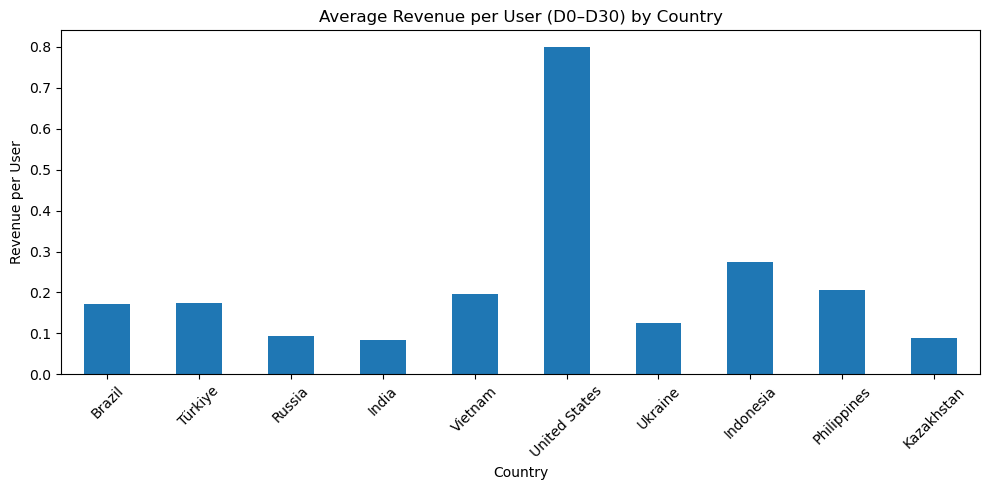

In [22]:
# 13. Average Rev/User per Country (all segments combined)

rev_country_mean = (
    summary_country
    .groupby("country")["rev_per_user_D30"]
    .mean()
    .reindex(top_countries)
)

plt.figure(figsize=(10, 5))
rev_country_mean.plot(kind="bar")
plt.title("Average Revenue per User (D0–D30) by Country")
plt.xlabel("Country")
plt.ylabel("Revenue per User")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


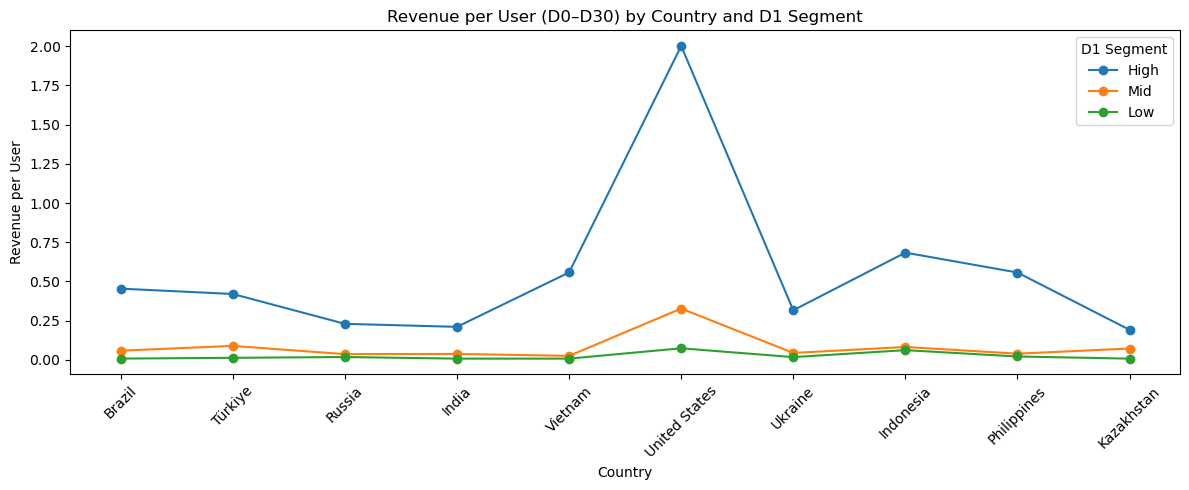

In [23]:
# 14. Rev/User by Country and D1 Segment

plt.figure(figsize=(12, 5))

for seg in ["High", "Mid", "Low"]:
    seg_data = summary_country[summary_country["d1_engagement_segment"] == seg]
    seg_mean = (
        seg_data.groupby("country")["rev_per_user_D30"]
        .mean()
        .reindex(top_countries)
    )
    plt.plot(seg_mean.index, seg_mean.values, marker="o", label=seg)

plt.title("Revenue per User (D0–D30) by Country and D1 Segment")
plt.xlabel("Country")
plt.ylabel("Revenue per User")
plt.xticks(rotation=45)
plt.legend(title="D1 Segment")
plt.tight_layout()
plt.show()


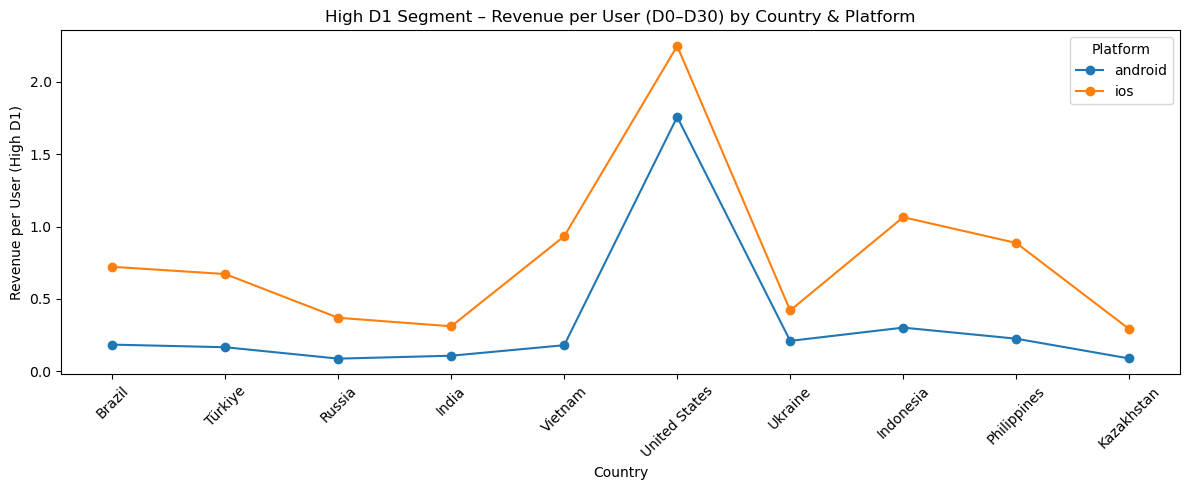

In [24]:
# 15. High D1 Segment – Rev/User by Country & Platform

high_seg = summary_country[summary_country["d1_engagement_segment"] == "High"]

plt.figure(figsize=(12, 5))
for plat in high_seg["platform"].unique():
    sub = high_seg[high_seg["platform"] == plat]
    sub_mean = (
        sub.groupby("country")["rev_per_user_D30"]
        .mean()
        .reindex(top_countries)
    )
    plt.plot(sub_mean.index, sub_mean.values, marker="o", label=plat)

plt.title("High D1 Segment – Revenue per User (D0–D30) by Country & Platform")
plt.xlabel("Country")
plt.ylabel("Revenue per User (High D1)")
plt.xticks(rotation=45)
plt.legend(title="Platform")
plt.tight_layout()
plt.show()


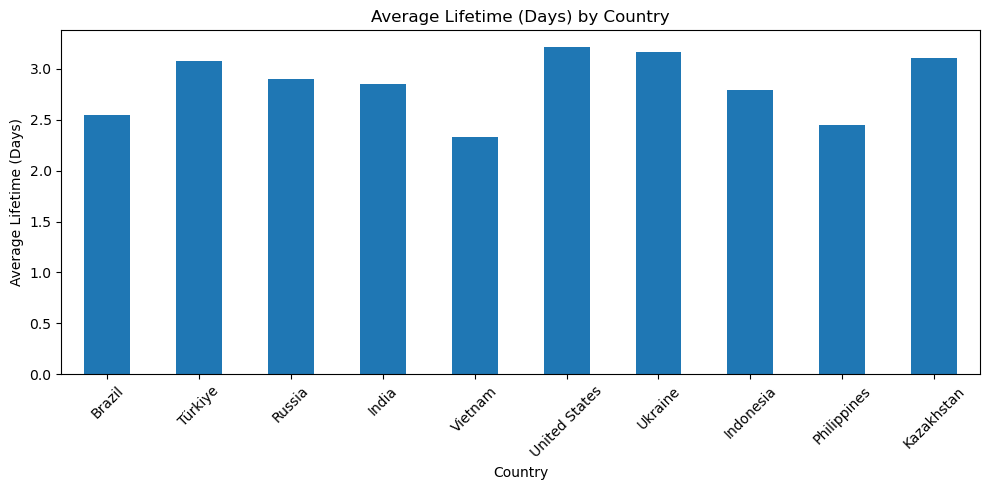

In [25]:
# 16. Average Lifetime (in days) per Country

# Compute user-level lifetime as the max day index within the first 30 days
lifetime = (
    df_30.groupby("user_id")["days_since_install"]
    .max()
    .reset_index()
    .rename(columns={"days_since_install": "lifetime_days"})
)

# Attach country information based on D1 row
user_country = (
    df[df["days_since_install"] == 0][["user_id", "country"]]
    .drop_duplicates()
)

lifetime_country = user_country.merge(lifetime, on="user_id", how="left")

country_lifetime = (
    lifetime_country
    .groupby("country")["lifetime_days"]
    .mean()
    .reset_index()
    .sort_values("lifetime_days", ascending=False)
)

country_lifetime.head(15)

# Visualize lifetime only for top countries
country_life_top = (
    country_lifetime[country_lifetime["country"].isin(top_countries)]
    .set_index("country")
    .reindex(top_countries)
)

plt.figure(figsize=(10, 5))
country_life_top["lifetime_days"].plot(kind="bar")
plt.title("Average Lifetime (Days) by Country")
plt.xlabel("Country")
plt.ylabel("Average Lifetime (Days)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
# 17. Skill Segmentation based on Win Rate

df_30 = df[df["days_since_install"].between(0, 29)].copy()

# Aggregate wins, losses and revenue per user
user_skill = (
    df_30.groupby("user_id")
    .agg(
        total_victories=("victory_count", "sum"),
        total_defeats=("defeat_count", "sum"),
        total_revenue=("total_revenue", "sum"),
        d1_segment=("d1_engagement_segment", "first"),
        platform=("platform", "first"),
    )
    .reset_index()
)

# Compute matches and win rate
user_skill["matches"] = user_skill["total_victories"] + user_skill["total_defeats"]
user_skill["win_rate"] = user_skill["total_victories"] / user_skill["matches"]
user_skill.loc[user_skill["matches"] == 0, "win_rate"] = np.nan

# Define skill segments using win-rate quartiles
skill_q25 = user_skill["win_rate"].quantile(0.25)
skill_q75 = user_skill["win_rate"].quantile(0.75)

def skill_segment(w):
    if pd.isna(w):
        return "No_matches"
    if w <= skill_q25:
        return "Low_skill"
    elif w <= skill_q75:
        return "Mid_skill"
    else:
        return "High_skill"

user_skill["skill_segment"] = user_skill["win_rate"].apply(skill_segment)
user_skill["skill_segment"].value_counts()


skill_segment
Mid_skill     569303
Low_skill     409759
High_skill    283849
No_matches    183385
Name: count, dtype: int64

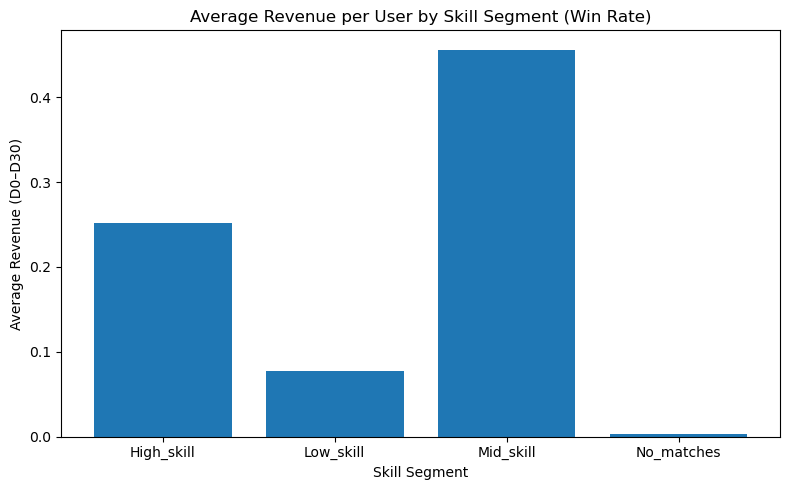

In [27]:
# 18. Revenue per User by Skill Segment

skill_summary = (
    user_skill.groupby("skill_segment")
    .agg(
        users=("user_id", "nunique"),
        avg_revenue=("total_revenue", "mean"),
    )
    .reset_index()
)

plt.figure(figsize=(8, 5))
plt.bar(skill_summary["skill_segment"], skill_summary["avg_revenue"])
plt.title("Average Revenue per User by Skill Segment (Win Rate)")
plt.xlabel("Skill Segment")
plt.ylabel("Average Revenue (D0–D30)")
plt.tight_layout()
plt.show()


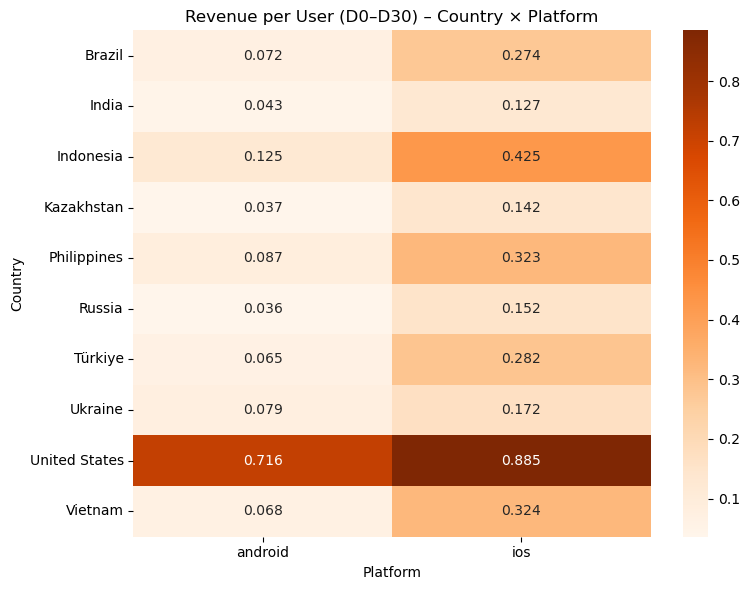

In [28]:
# 19. Country × Platform – Rev/User Heatmap

country_platform_rev = (
    summary_country.groupby(["country", "platform"])["rev_per_user_D30"]
    .mean()
    .reset_index()
)

pivot = country_platform_rev.pivot(
    index="country",
    columns="platform",
    values="rev_per_user_D30"
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="Oranges")
plt.title("Revenue per User (D0–D30) – Country × Platform")
plt.xlabel("Platform")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [29]:
# 20. IAP vs Ad Revenue Split and Ad Ratio by Country

rev_split = (
    df_30_top.groupby(["country", "d1_engagement_segment"])
    .agg(
        iap_rev=("iap_revenue", "sum"),
        ad_rev=("ad_revenue", "sum"),
    )
    .reset_index()
)

# Share of ad revenue within total revenue
rev_split["ad_ratio"] = rev_split["ad_rev"] / (rev_split["iap_rev"] + rev_split["ad_rev"])
rev_split.head()


,country,d1_engagement_segment,iap_rev,ad_rev,ad_ratio
0,Brazil,High,3453.541539,2047.373821,0.372188
1,Brazil,Low,64.664167,149.504960,0.698070
2,Brazil,Mid,929.468288,868.831328,0.483140
3,India,High,1196.205115,1023.307218,0.461050
4,India,Low,20.705793,49.417291,0.704722


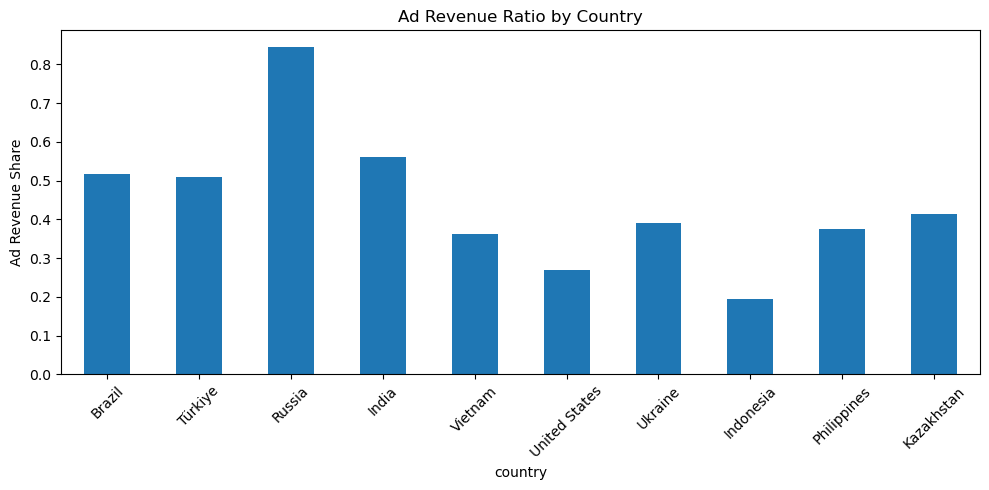

In [30]:
plt.figure(figsize=(10, 5))
country_ad = rev_split.groupby("country")["ad_ratio"].mean().reindex(top_countries)
country_ad.plot(kind="bar")
plt.title("Ad Revenue Ratio by Country")
plt.ylabel("Ad Revenue Share")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


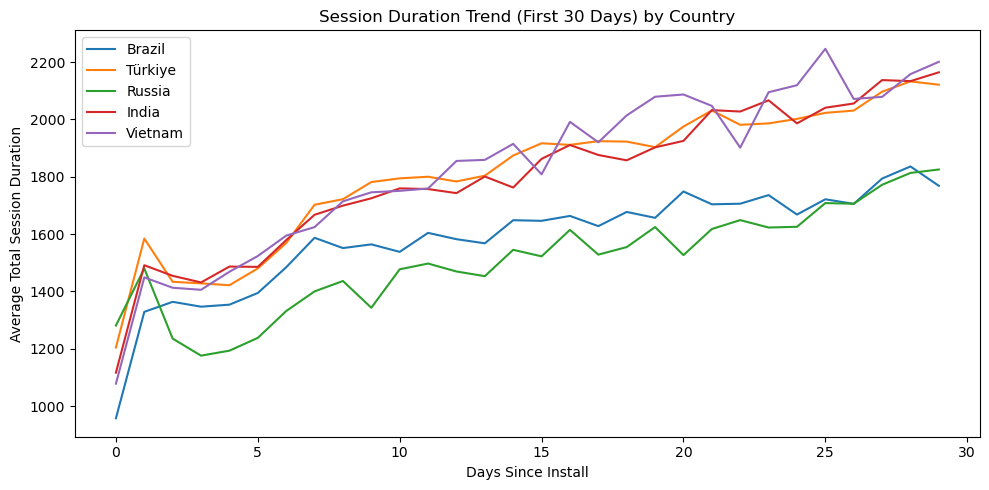

In [31]:
# 21. Session Duration Trend over the First 30 Days

trend = (
    df_30.groupby(["country", "days_since_install"])["total_session_duration"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
for c in top_countries[:5]:
    sub = trend[trend["country"] == c]
    plt.plot(sub["days_since_install"], sub["total_session_duration"], label=c)

plt.legend()
plt.title("Session Duration Trend (First 30 Days) by Country")
plt.xlabel("Days Since Install")
plt.ylabel("Average Total Session Duration")
plt.tight_layout()
plt.show()


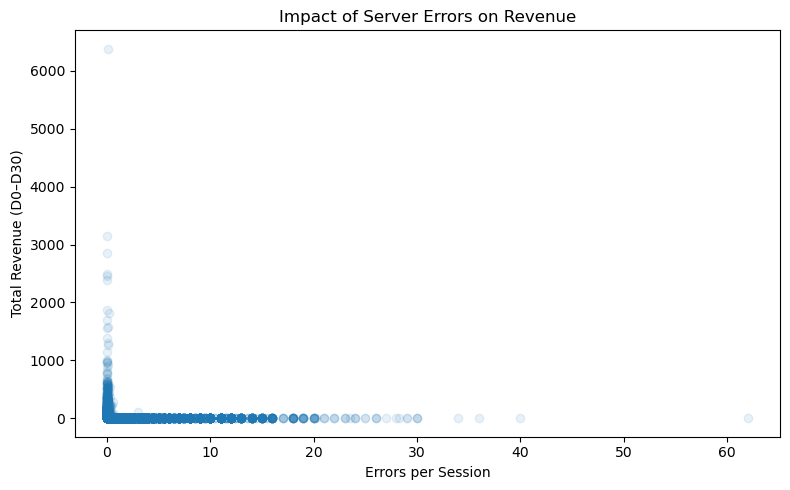

In [32]:
# 22. Error per Session vs Revenue (Impact of Server Errors)

user_errors = (
    df_30.groupby("user_id")
    .agg(
        total_errors=("server_connection_error", "sum"),
        total_sessions=("total_session_count", "sum"),
        country=("country", "first"),
        d1_segment=("d1_engagement_segment", "first"),
        platform=("platform", "first"),
        total_rev=("total_revenue", "sum"),
    )
    .reset_index()
)

user_errors["error_per_session"] = (
    user_errors["total_errors"] / user_errors["total_sessions"]
)
user_errors.loc[user_errors["total_sessions"] == 0, "error_per_session"] = np.nan

plt.figure(figsize=(8, 5))
plt.scatter(user_errors["error_per_session"], user_errors["total_rev"], alpha=0.1)
plt.xlabel("Errors per Session")
plt.ylabel("Total Revenue (D0–D30)")
plt.title("Impact of Server Errors on Revenue")
plt.tight_layout()
plt.show()


In [33]:
# 23. Weighted D30 Retention – Country × D1 Segment
# Here we aggregate Android + iOS per country/segment
# using install_users as weights.

tmp = ret_country_D30.copy()
tmp["weighted_ret"] = tmp["D30_retention"] * tmp["install_users"]

ret_country_D30_seg = (
    tmp
    .groupby(["country", "d1_engagement_segment"], as_index=False)
    .agg(
        D30_retention_weighted=("weighted_ret", "sum"),
        total_installs=("install_users", "sum")
    )
)

ret_country_D30_seg["D30_retention_weighted"] = (
    ret_country_D30_seg["D30_retention_weighted"] / ret_country_D30_seg["total_installs"]
)

ret_country_D30_seg = ret_country_D30_seg.drop(columns="total_installs")
ret_country_D30_seg.head()


,country,d1_engagement_segment,D30_retention_weighted
0,Brazil,High,0.001804
1,Brazil,Low,0.000213
2,Brazil,Mid,0.000462
3,India,High,0.001724
4,India,Low,0.000000


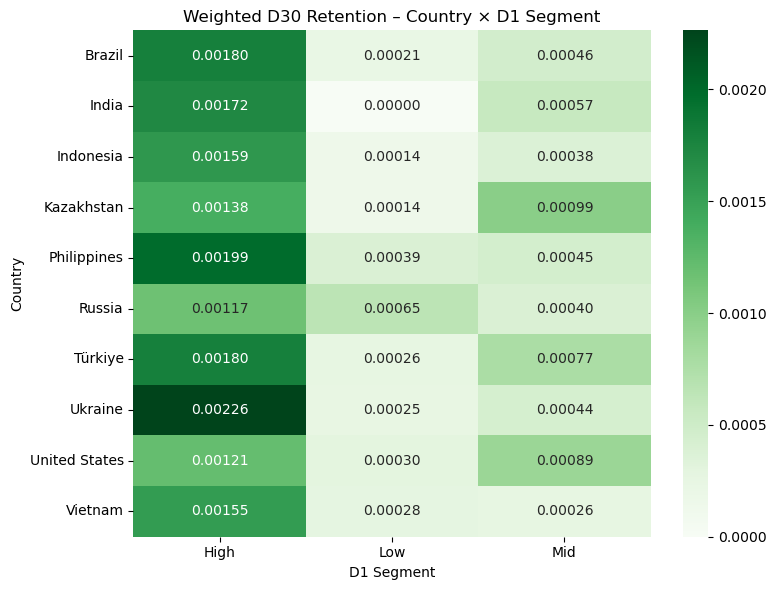

In [34]:
pivot_ret = ret_country_D30_seg.pivot(
    index="country",
    columns="d1_engagement_segment",
    values="D30_retention_weighted",
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_ret, annot=True, fmt=".5f", cmap="Greens")
plt.title("Weighted D30 Retention – Country × D1 Segment")
plt.xlabel("D1 Segment")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [35]:
# 24. D1 Low Segment → D2 / D3 Conversion (Segment Movement)

# Identify all users who were Low on D1
low_users = df[df["d1_engagement_segment"] == "Low"]["user_id"].unique()

# Extract D2 and D3 activity
d2 = df[df["days_since_install"] == 1].copy()
d3 = df[df["days_since_install"] == 2].copy()

# Keep only D1-Low users on D2 and D3
d2_low = d2[d2["user_id"].isin(low_users)].copy()
d3_low = d3[d3["user_id"].isin(low_users)].copy()

# Compute quartiles for D2 duration among D1-Low users
q25_d2 = d2_low["total_session_duration"].quantile(0.25)
q75_d2 = d2_low["total_session_duration"].quantile(0.75)

def seg_d2(x):
    if x <= q25_d2:
        return "Low"
    elif x <= q75_d2:
        return "Mid"
    else:
        return "High"

# Compute quartiles for D3 duration among D1-Low users
q25_d3 = d3_low["total_session_duration"].quantile(0.25)
q75_d3 = d3_low["total_session_duration"].quantile(0.75)

def seg_d3(x):
    if x <= q25_d3:
        return "Low"
    elif x <= q75_d3:
        return "Mid"
    else:
        return "High"

# Safely assign D2 and D3 segments
d2_low.loc[:, "d2_seg"] = d2_low["total_session_duration"].apply(seg_d2)
d3_low.loc[:, "d3_seg"] = d3_low["total_session_duration"].apply(seg_d3)

# Compute conversion ratios (distribution of segments)
conv_d2 = d2_low["d2_seg"].value_counts(normalize=True)
conv_d3 = d3_low["d3_seg"].value_counts(normalize=True)

print("D2 Conversion Rates (from D1-Low):\n", conv_d2)
print("\nD3 Conversion Rates (from D1-Low):\n", conv_d3)


D2 Conversion Rates (from D1-Low):
 d2_seg
Mid     0.499989
Low     0.250017
High    0.249994
Name: proportion, dtype: float64

D3 Conversion Rates (from D1-Low):
 d3_seg
Mid     0.50
Low     0.25
High    0.25
Name: proportion, dtype: float64


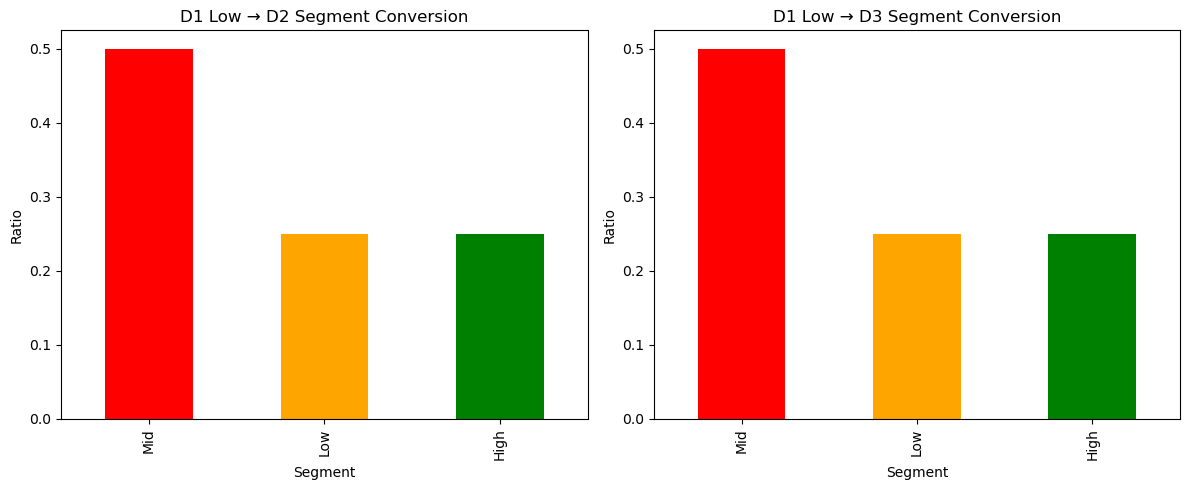

In [36]:
# 25. Visualization – D1 Low → D2 & D3 Segment Conversion

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

conv_d2.plot(kind="bar", ax=ax[0],
             title="D1 Low → D2 Segment Conversion",
             color=["red", "orange", "green"])
conv_d3.plot(kind="bar", ax=ax[1],
             title="D1 Low → D3 Segment Conversion",
             color=["red", "orange", "green"])

for a in ax:
    a.set_xlabel("Segment")
    a.set_ylabel("Ratio")

plt.tight_layout()
plt.show()


In [37]:
# 26. D30 Retention for Users Converting from Low → Mid on D2

# Users who were Low on D1 but show Mid-level engagement on D2
low_to_mid = d2_low[d2_low["d2_seg"] == "Mid"]["user_id"].unique()

# Users who are still active on D30 (days_since_install == 29)
d30_users = df[df["days_since_install"] == 29]["user_id"].unique()

# D30 retention among the Low → Mid cohort
ret_low_to_mid = len(set(low_to_mid) & set(d30_users)) / len(low_to_mid)
print("D30 retention for users converting from D1-Low → D2-Mid:", ret_low_to_mid)


D30 retention for users converting from D1-Low → D2-Mid: 0.0005745348477482654


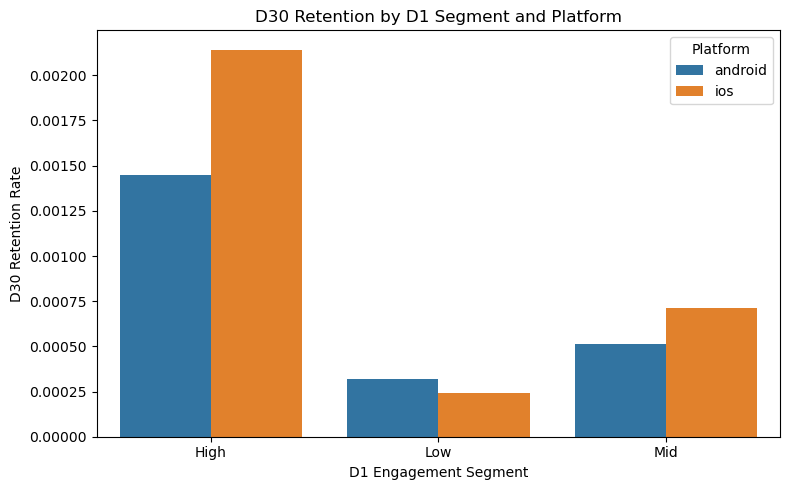

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only needed columns
plot_ret = summary[["d1_engagement_segment", "platform", "D30_retention"]].copy()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=plot_ret,
    x="d1_engagement_segment",
    y="D30_retention",
    hue="platform"
)

plt.title("D30 Retention by D1 Segment and Platform")
plt.xlabel("D1 Engagement Segment")
plt.ylabel("D30 Retention Rate")
plt.legend(title="Platform")
plt.tight_layout()
plt.show()


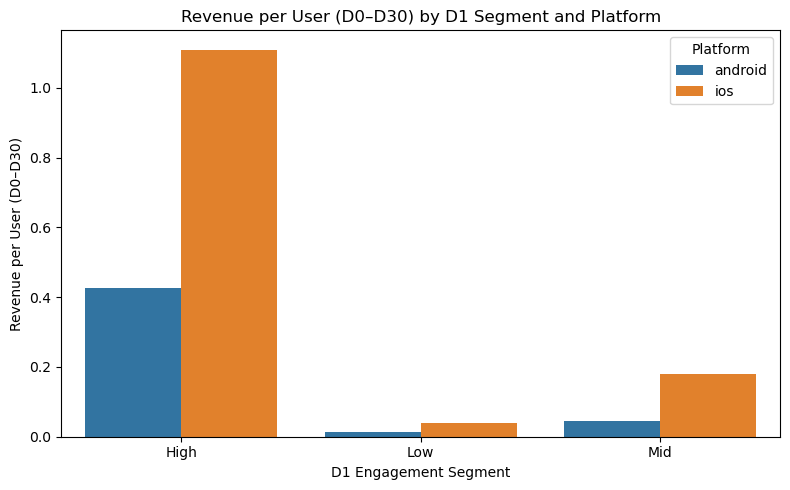

In [39]:
# Again use summary table
plot_rev = summary[["d1_engagement_segment", "platform", "rev_per_user_D30"]].copy()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=plot_rev,
    x="d1_engagement_segment",
    y="rev_per_user_D30",
    hue="platform"
)

plt.title("Revenue per User (D0–D30) by D1 Segment and Platform")
plt.xlabel("D1 Engagement Segment")
plt.ylabel("Revenue per User (D0–D30)")
plt.legend(title="Platform")
plt.tight_layout()
plt.show()
